<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [16]:
# Set your student number
student_number = 400100746
Name = 'Hosein'
Last_Name = 'Anjidani'

In [5]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

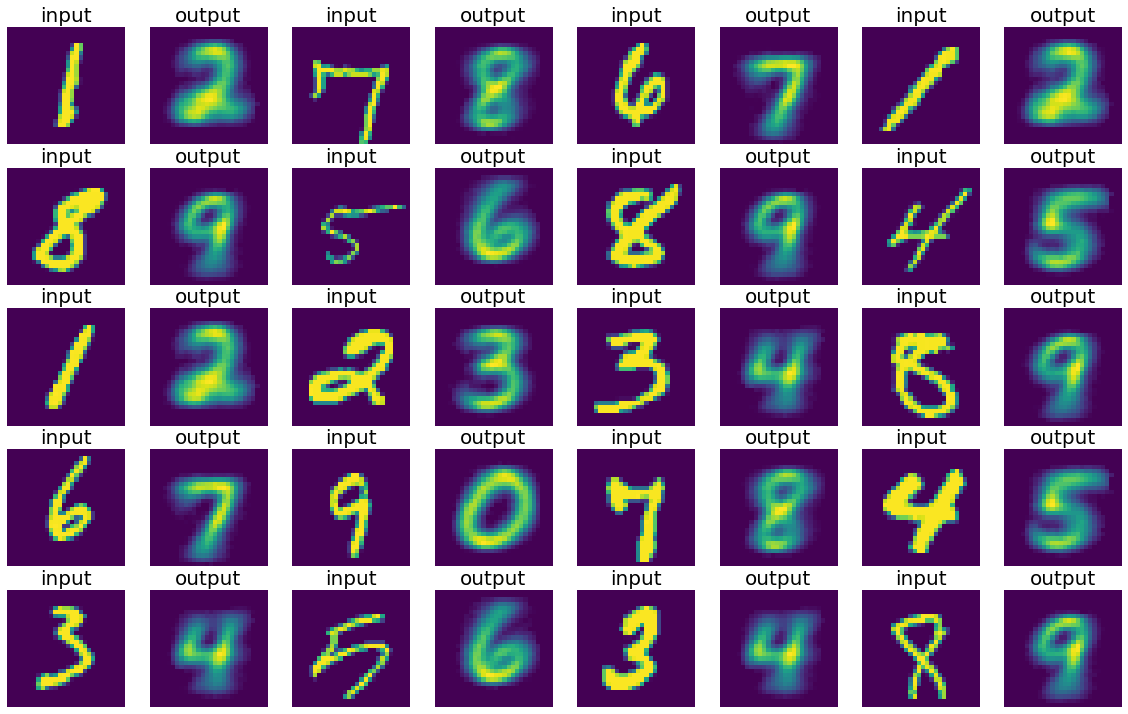

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

In [6]:
# import
import torch
from torch import nn
from ae_helper import get_data
from sklearn.model_selection import train_test_split
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [7]:
X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)
X_train = X_train[:, np.newaxis, :, :]
X_val = X_val[:, np.newaxis, :, :]
print(X_train.shape)
print(X_val.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(50400, 1, 28, 28)
(5600, 1, 28, 28)


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=7, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        en = self.encoder(x)
        de = self.decoder(en)
        return de

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [9]:
class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X[i], self.Y[i]

In [10]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [17]:
def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:
    model.train()
    total_loss = 0.0
    loss_function = nn.MSELoss().to(device)

    for batch_idx, (input_data, target_data) in enumerate(dataloader):
        input_data = input_data.to(device)
        target_data = target_data.unsqueeze(1).to(device)
        optimizer.zero_grad()
        reconstructed_data = model(input_data)
        loss = loss_function(reconstructed_data, target_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    return average_loss

def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    total_loss = 0.0
    loss_function = nn.MSELoss()

    with torch.no_grad():
        for batch_idx, (input_data, target_data) in enumerate(dataloader):
            input_data = input_data.to(device)
            target_data = target_data.unsqueeze(1).to(device)
            reconstructed_data = model(input_data)
            loss = loss_function(reconstructed_data, target_data)
            total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    return average_loss


## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [18]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
ae = AutoEncoder().to(device=device)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.01)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [21]:
num_epochs = 100
criterion = nn.MSELoss()
best_validation_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    # Training
    train_loss = train_autoencoder(model=ae, optimizer=optimizer, dataloader=train_dataloader)

    # Validation
    validation_loss = eval_autoencoder(model=ae, dataloader=val_dataloader)

    # Logging
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {validation_loss:.4f}')

    # Check if current model is the best so far
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        best_model_state = ae.state_dict()
        # Save the best model state
        torch.save(best_model_state, 'best.pth')

    # Early stopping based on no significant improvement
    if epoch > 10 and ((validation_loss - best_validation_loss) / best_validation_loss) < 0.05:
        break


Epoch [1/100], Train Loss: 0.0541, Val Loss: 0.0548
Epoch [2/100], Train Loss: 0.0540, Val Loss: 0.0548
Epoch [3/100], Train Loss: 0.0540, Val Loss: 0.0549
Epoch [4/100], Train Loss: 0.0539, Val Loss: 0.0548
Epoch [5/100], Train Loss: 0.0538, Val Loss: 0.0550
Epoch [6/100], Train Loss: 0.0538, Val Loss: 0.0552
Epoch [7/100], Train Loss: 0.0537, Val Loss: 0.0551
Epoch [8/100], Train Loss: 0.0536, Val Loss: 0.0553
Epoch [9/100], Train Loss: 0.0536, Val Loss: 0.0553
Epoch [10/100], Train Loss: 0.0535, Val Loss: 0.0553
Epoch [11/100], Train Loss: 0.0534, Val Loss: 0.0554
Epoch [12/100], Train Loss: 0.0533, Val Loss: 0.0555


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [22]:
# Load the best model state into the model object
if torch.load('best.pth') is not None:
    ae.load_state_dict(torch.load('best.pth'))

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

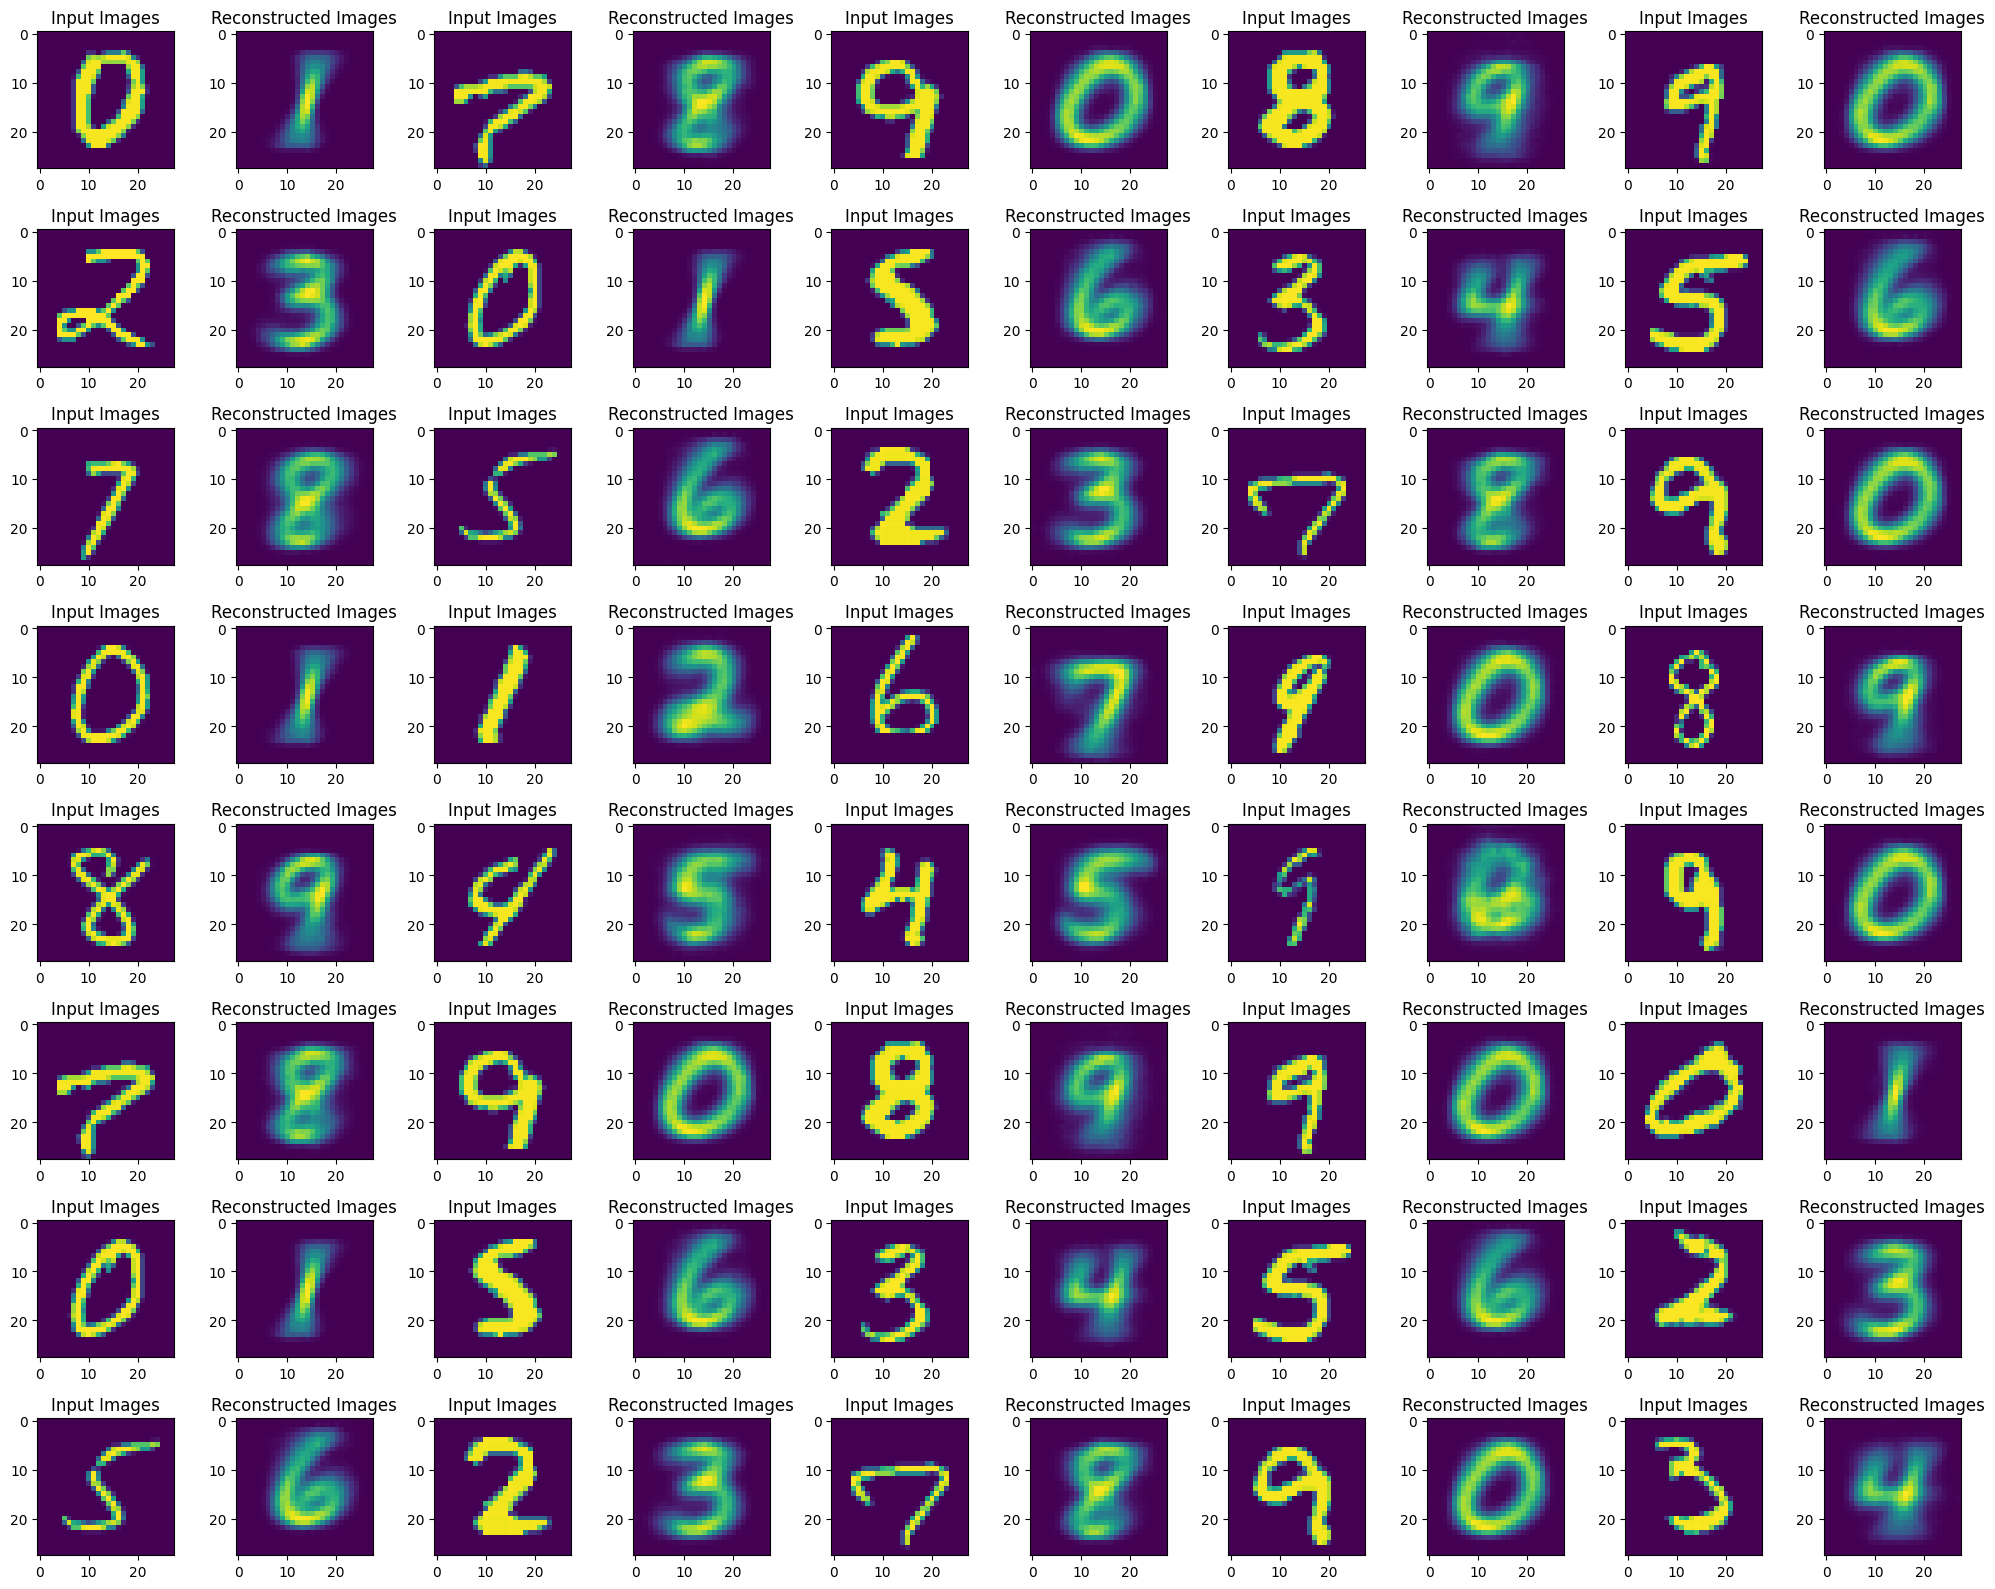

In [23]:
#select random index of X_test:
random_indx = np.random.choice(len(X_test), size=40, replace=False)
chosen_data = np.expand_dims(X_test[random_indx], axis=1)

# Pass the selected examples through the model
with torch.no_grad():
    ae.eval()
    reconstructed_data = ae(torch.from_numpy(chosen_data).to(device))

# Reshape the output tensor to 2D images
reconstructed_images = reconstructed_data.cpu().numpy()


# Create a figure with 8 rows and 10 columns
fig, axes = plt.subplots(8, 10, figsize=(20, 16))

# Iterate over the rows and columns
for j in range(8):
    for i in range(0, 10, 2):
        idx = (i//2) * 5 + j
        # Plot
        axes[j, i].imshow(chosen_data.squeeze()[idx])
        axes[j, i+1].imshow(reconstructed_images.squeeze()[idx])
        axes[j, i+1].set_title('Reconstructed Images')
        axes[j, i].set_title('Input Images')
plt.tight_layout()
plt.show()